# Sequence Labelling data (20 marks)

In [1]:
#Import Libraries

import os
import numpy as np
import pandas as pd  # use pandas to load data from CSV files
from hmmlearn import hmm  # We recommend using this class if building an HMM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the data:

In [2]:
# Loading the data

data_path = "activity_recognition_dataset/S1_Dataset"
files = os.listdir(data_path)

combined_data = []

for file in files:    
    if file == "README.txt":
        continue
    
    try:
        # load a single sequence from the file (Dataframe)
        # The CSV files have columns without a header, so header=None is used
        seq_dataframe = pd.read_csv(os.path.join(data_path, file), header=None, names=["time", "frontal acc", "vertical acc", "lateral acc", "antenna ID", "RSSI", "phase", "frequency", "label"])
        
        # put the ID of the sequence into the dataframe as an EXTRA COLUMN equal to the filename
        seq_dataframe['seqID'] = file  # use filename as ID
        combined_data.append(seq_dataframe)  # put the data frame into a list
    except:
        print(f"Could not load file {file}. Skipping.")

In [3]:
# Sequence Labelling

# the pandas dataframe stores data in a table with headers
input_cols = ["frontal acc", "vertical acc", "lateral acc", "RSSI", "phase", "frequency"]  # column headers for the input features
output_col = "label"  # column header for the output label

# get the relevant columns from the pandas dataframes and convert to numpy arrays
X_by_seq = []  # store a list of numpy arrays containing the input features for each sequence
y_by_seq = []  # store a list of 1-D numpy arrays containing the target activity labels for each sequence

for seq_table in combined_data:
    X_by_seq.append(seq_table[input_cols].values)
    y_by_seq.append(seq_table[output_col].values - 1)    # subtract one from the label so that labels start from 0
    
n_states = np.unique(np.concatenate(y_by_seq)).size  # how many classes/states are there?

In [4]:
# create train/test split. Sequences are kept complete.
X_by_seq_tr, X_by_seq_test, y_by_seq_tr, y_by_seq_test = train_test_split(X_by_seq, y_by_seq, test_size=0.2, random_state=21)  # You may wish to make further splits of the data or to modify this split.

## Standardise data:

In [5]:
# Standardise input data
'''
Standardise X_by_seq_tr
'''
# Concatenate arrays
concatenated_data = np.concatenate(X_by_seq_tr, axis=0)

# Apply StandardScaler
scaler = StandardScaler()
standardized_data = scaler.fit_transform(concatenated_data)

# Reshape the standardized data back into the original structure
start = 0
X_by_seq_tr_scaled = []
for array in X_by_seq_tr:
    end = start + len(array)
    X_by_seq_tr_scaled.append(standardized_data[start:end])
    start = end

squashed = np.concatenate(X_by_seq_tr_scaled, axis=0)
# print(squashed)
print(np.mean(squashed, axis=0)) # [0, 0, 0, 0, 0, 0]
print(np.var(squashed, axis=0)) # [1. 1. 1. 1. 1. 1.]

[-3.53216540e-16  2.68884563e-17 -9.77762048e-18  4.60159264e-16
  3.75827287e-16 -3.66232997e-15]
[1. 1. 1. 1. 1. 1.]


In [6]:
# Standardise input data
'''
Standardise X_by_seq_test
'''
# Concatenate arrays
concatenated_data2 = np.concatenate(X_by_seq_test, axis=0)

# Apply StandardScaler
scaler = StandardScaler()
standardized_data2 = scaler.fit_transform(concatenated_data2)

# Reshape the standardized data back into the original structure
start = 0
X_by_seq_test_scaled = []
for array in X_by_seq_test:
    end = start + len(array)
    X_by_seq_test_scaled.append(standardized_data2[start:end])
    start = end

squashed = np.concatenate(X_by_seq_test_scaled, axis=0)
print(squashed)
print(np.mean(squashed, axis=0))
print(np.var(squashed, axis=0))

[[ 0.1657036   0.56393296 -0.1494588   0.18584669  1.04858644  1.82950928]
 [ 0.1657036   0.56393296 -0.1494588   0.05328611  1.12520105  1.53299713]
 [ 0.7655184  -1.98622922  0.32160416 -1.67000136 -0.84097796 -0.54258795]
 ...
 [ 0.67074562 -2.08155676 -0.20179862  0.18584669  0.86513188  1.82950928]
 [ 0.67074562 -2.08155676 -0.20179862  0.58352841  0.85369883  1.53299713]
 [ 1.49166101 -1.93855507  0.26926434 -0.34439561 -1.33619137 -0.2460758 ]]
[-9.51672842e-18 -2.09368025e-16 -1.90334568e-17 -3.33085495e-16
 -6.18587347e-17 -3.42126387e-15]
[1. 1. 1. 1. 1. 1.]


In [7]:
# Record which observations occur given each state (activity label)
X_given_y = [[] for _ in range(n_states)]  # empty list where we will record the observations that occur given each activity label
# print(X_given_y)
for s, X_seq in enumerate(X_by_seq_tr_scaled): # X_by_seq_tr_scaled is a list of 2-D numpy arrays => x_seq = 2D numpy array where each row is an observation
    for i in range(X_seq.shape[0]): # iterating over each observation in a file (X_seq contains a list of all observations in a file)
        state_i = y_by_seq_tr[s][i] # corresponding label for the observation
        X_given_y[state_i].append(X_seq[i, :][None, :]) # X_given_y[state_i] = all the rows of the ith observation in the file X_seq


In [8]:
# Record the mean feature values for observations in each state
means = np.zeros((n_states, len(input_cols)))
# print(means)

# Record the variance of feature values for observations in each state
diagonal_covars = np.zeros((n_states, len(input_cols)))
# print(diagonal_covars)

for state in range(n_states):
    means[state] = np.mean(X_given_y[state], axis=0)
    diagonal_covars[state, :] = np.var(X_given_y[state], axis=0)

print(means)
print()
print(diagonal_covars)

[[-1.1354286   1.2117892   0.29115027 -0.12662483 -0.05700205 -0.01892787]
 [-0.64958174  1.06748664  0.34368337  0.04911889  0.09143578 -0.07144643]
 [ 0.70595427 -0.78837478 -0.18837384 -0.00592088  0.01690584  0.0147193 ]
 [-1.47128222  1.27910035  0.09505739  0.89356352 -0.06108273  0.06522177]]

[[0.29504857 0.04589795 0.41766505 0.36388899 1.00718513 0.98939068]
 [0.37447701 0.04472122 0.37507674 0.66798853 0.98968427 1.13309524]
 [0.17160318 0.07212618 1.28622768 1.18536971 0.99944052 0.98577839]
 [0.27784271 0.06603066 0.65098122 2.48747066 0.92990847 0.9792632 ]]


In [9]:
# 60 1-D arrays corresponding to the label column in each file
# (all values have 1 subtracted from them)
# print(y_by_seq[:][0])
first_elements = [arr[0] for arr in y_by_seq]

print(first_elements)
# print(y_by_seq)
# print(X_by_seq)
# 60 Nx6 arrays, where N is the number of rows in a file
# Each of the 60 arrays corresponding to the data in each file from the columns specified above:
# ["frontal acc", "vertical acc", "lateral acc", "RSSI", "phase", "frequency"]

# print(n_states) # 4 states
# combined_data: all data as is with name of file as an additional column

[0, 3, 2, 0, 3, 3, 3, 0, 0, 0, 0, 0, 1, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 2, 3, 3, 0, 3, 2, 3, 2, 2, 2, 1, 0, 0, 0, 0, 0, 3, 3, 3, 3, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 2, 0, 0, 0, 3, 3]


In [10]:
# Calculating start probabilities (pi)
counts = np.bincount(np.array(first_elements))
occurrences = counts[0:4]  # Assuming you want counts for values 0, 1, 2, and 3
print(occurrences)

start_prob = occurrences/occurrences.sum()
print("\nstart_prob:",start_prob)

[20  3 13 24]

start_prob: [0.33333333 0.05       0.21666667 0.4       ]


In [11]:
# Calculating transition probabilities (A)
data = y_by_seq

unique_values = np.unique(np.concatenate(data))
num_values = len(unique_values)

transition_matrices = []

for array in data:
    transition_mat = np.zeros((num_values, num_values), dtype=int)
    for i in range(1, len(array)):
        prev_value = np.where(unique_values == array[i - 1])[0][0]
        current_value = np.where(unique_values == array[i])[0][0]
        transition_mat[prev_value, current_value] += 1
    transition_matrices.append(transition_mat)

# print(transition_matrices)
sum_transition_matrix = np.sum(transition_matrices, axis=0)
# print(sum_transition_matrix)
# print(sum_transition_matrix.sum())

trans_mat = sum_transition_matrix / sum_transition_matrix.sum()

print("trans_mat:\n",trans_mat)
trans_mat[0]

trans_mat:
 [[2.86654458e-01 0.00000000e+00 1.37346915e-03 1.06825379e-03]
 [1.90759605e-05 8.25607569e-02 9.53798024e-05 8.20266300e-04]
 [1.14455763e-03 1.90759605e-05 5.89103811e-01 4.95974972e-04]
 [1.03010187e-03 9.34722063e-04 2.09835565e-04 3.44702606e-02]]


array([0.28665446, 0.        , 0.00137347, 0.00106825])

## Training a sequence labeller

In [12]:
# Just to ensure no rounding errors such as:
# ValueError: transmat_ rows must sum to 1 (got [0.28909618 0.08349548 0.59076342 0.03664492])
# The value above actually is equal to 1, but still results in an error
trans_mat_norm = trans_mat / trans_mat.sum(axis=1, keepdims=True)
# print(trans_mat_norm)
# print()
# print(trans_mat)

n_components = 4
model = hmm.GaussianHMM(n_components=n_components, covariance_type="diag", init_params='')
model.startprob_ = start_prob
model.transmat_ = trans_mat_norm
model.means_ = means
model.covars_ = diagonal_covars

In [13]:
# Training the GaussianHMM model:

# Lengths of each of the sequences
sequence_lengths = [len(seq) for seq in X_by_seq_tr_scaled]
# print(sequence_lengths)

# Train the model using fit method and providing lengths
model.fit(np.vstack(X_by_seq_tr_scaled), lengths=sequence_lengths)

GaussianHMM(init_params='', n_components=4)

In [14]:
# Evaluating results on test set

# Make predictions on the test set using predict and storing them in a similar format to y_by_seq_test
y_pred = [model.predict(seq) for seq in X_by_seq_test_scaled]


# Flatten the true labels
true_labels_flat = [label for seq in y_by_seq_test for label in seq]

# Flatten the predicted labels
predicted_labels_flat = [label for seq in y_pred for label in seq]

# Calculate accuracy
accuracy = accuracy_score(true_labels_flat, predicted_labels_flat)

print(f"Accuracy: {accuracy}")

# Evaluate the accuracy
# accuracy = accuracy_score(y_by_seq_test, y_pred)
# print(f"Accuracy: {accuracy}")

Accuracy: 0.6606395446174451


In [15]:
total_samples = 0
correct_pred = 0

for true_labels, predicted_labels in zip(y_by_seq_test, y_pred):
#     print("True Labels:", true_labels)
#     print("Predicted Labels:", predicted_labels)
    a = true_labels==predicted_labels
#     print(a)
#     print("Length of sequence:", len(predicted_labels))
#     print("Number of trues:", sum(a))
    total_samples += len(predicted_labels)
    correct_pred += sum(a)
#     print("---")

In [16]:
print(correct_pred)
print(total_samples)
print("Accuracy:", correct_pred/total_samples)

3946
5973
Accuracy: 0.6606395446174451


## Plot a transition matrix

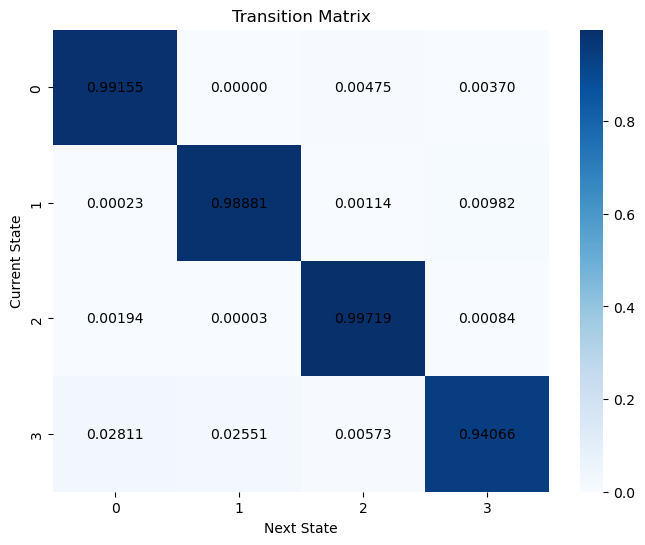

In [17]:
# Assuming trans_mat_norm is your transition matrix
# trans_mat_norm

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(trans_mat_norm, annot=False, cmap="Blues")

# Annotate each cell individually
for i in range(trans_mat_norm.shape[0]):
    for j in range(trans_mat_norm.shape[1]):
        plt.text(j + 0.5, i + 0.5, f'{trans_mat_norm[i, j]:.5f}',
                 ha='center', va='center', fontsize=10, color='black')

plt.title('Transition Matrix')
plt.xlabel('Next State')
plt.ylabel('Current State')
plt.show()


## Identify any features that are particularly informative

In [18]:
# Get the means
means = model.means_
# means

feature_names = [f"Feature{i}" for i in range(1, 6 + 1)]

# Iterate through means and feature names to analyze any features that are particularly informative
for state, mean_values in enumerate(means):
    print(f"\tState {state}")
    print(f"Feature \t Means")
    print("------------------------")
    for feature, mean in zip(feature_names, mean_values):
        print(f"{feature} \t {mean:.2f}")
    print()

	State 0
Feature 	 Means
------------------------
Feature1 	 -1.22
Feature2 	 1.28
Feature3 	 0.17
Feature4 	 -0.03
Feature5 	 -0.02
Feature6 	 -0.01

	State 1
Feature 	 Means
------------------------
Feature1 	 -0.39
Feature2 	 0.99
Feature3 	 0.45
Feature4 	 -0.17
Feature5 	 0.03
Feature6 	 -0.05

	State 2
Feature 	 Means
------------------------
Feature1 	 0.70
Feature2 	 -0.78
Feature3 	 -0.18
Feature4 	 -0.01
Feature5 	 0.02
Feature6 	 0.01

	State 3
Feature 	 Means
------------------------
Feature1 	 -1.72
Feature2 	 1.30
Feature3 	 0.28
Feature4 	 0.34
Feature5 	 -0.11
Feature6 	 0.01

